<a href="https://colab.research.google.com/github/sanchit2843/GAN-applications/blob/master/pixtopix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -i https://test.pypi.org/simple/ supportlib
import supportlib.gettingdata as getdata
import matplotlib.pyplot as plt
import time
import datetime
from torch.autograd import Variable
import sys
import numpy as np
import torch
from torch import nn

Looking in indexes: https://test.pypi.org/simple/


In [2]:
getdata.kaggle()

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset

100% 2.37G/2.38G [00:56<00:00, 55.8MB/s]
100% 2.38G/2.38G [00:56<00:00, 45.3MB/s]


In [0]:
getdata.zipextract('/content/pix2pix-dataset.zip')
getdata.tarextract('/content/cityscapes.tar.gz')

In [0]:
from torch.utils.data import Dataset, DataLoader
class pix2pix_dataset(Dataset):
  def __init__(self,image_dir,transform = None):
    
    self.img_dir = image_dir
    self.transform = transform
    self.id = os.listdir(self.img_dir)
    
  def __len__(self):
    return len(self.id)
  def __getitem__(self,idx):
    img_name = os.path.join(self.img_dir, self.id[idx])
    image = cv2.imread(img_name)
    img1,img2 = image[:,:256],image[:,256:]
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)
      
    return img1,img2

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((256,256)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

data = pix2pix_dataset('/content/cityscapes/train',transform)
train_loader = DataLoader(data,batch_size = 32,shuffle = True)

In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [0]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [22]:
gen =  GeneratorUNet().to('cuda')
from torchsummary import summary
summary(gen,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
          UNetDown-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
          UNetDown-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
         UNetDown-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [0]:
dis = Discriminator().to('cuda')

In [25]:
gen.apply(weights_init_normal)
dis.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [0]:
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=0.0005, betas=(0.5, 0.999))
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

In [0]:
img_height,img_width = 256,256

In [0]:
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

In [0]:
!mkdir state_dict

In [0]:
class OneCycle(object):
    """
    In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during 
    whole run with 2 steps of equal length. During first step, increase the learning rate 
    from lower learning rate to higher learning rate. And in second step, decrease it from 
    higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one 
    addition to this. - During last few hundred/thousand iterations of cycle reduce the 
    learning rate to 1/100th or 1/1000th of the lower learning rate.
    Also, Author suggests that reducing momentum when learning rate is increasing. So, we make 
    one cycle of momentum also with learning rate - Decrease momentum when learning rate is 
    increasing and increase momentum when learning rate is decreasing.
    Args:
        nb              Total number of iterations including all epochs
        max_lr          The optimum learning rate. This learning rate will be used as highest 
                        learning rate. The learning rate will fluctuate between max_lr to
                        max_lr/div and then (max_lr/div)/div.
        momentum_vals   The maximum and minimum momentum values between which momentum will
                        fluctuate during cycle.
                        Default values are (0.95, 0.85)
        prcnt           The percentage of cycle length for which we annihilate learning rate
                        way below the lower learnig rate.
                        The default value is 10
        div             The division factor used to get lower boundary of learning rate. This
                        will be used with max_lr value to decide lower learning rate boundary.
                        This value is also used to decide how much we annihilate the learning 
                        rate below lower learning rate.
                        The default value is 10.
    """
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        
    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    
    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom

In [0]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0, 1)
    return image

In [0]:
def vis_gen(img1,img2,gen):
    fig,axes = plt.subplots(figsize=(7,5), nrows = 1, ncols=3)
    img1 = im_convert(img1)
    img2 = im_convert(img2)
    img3 = im_convert(gen)
    axes[0].imshow(img1)
    axes[0].set_title('groundtruth')
    axes[1].imshow(img2)
    axes[1].set_title('input')
    
    axes[2].imshow(img3)
    axes[2].set_title('gen')
    
    plt.show()

[Epoch 0/200] [Batch 92/93] [D loss: 0.030797] [G loss: 22.976992, pixel: 0.220004, adv: 0.976627] ETA: 16:07:16.559102

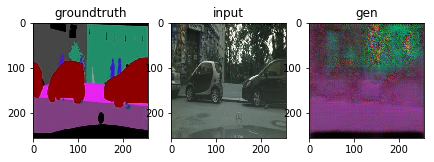

[Epoch 10/200] [Batch 92/93] [D loss: 0.046748] [G loss: 15.950584, pixel: 0.150579, adv: 0.892645] ETA: 15:22:11.126802

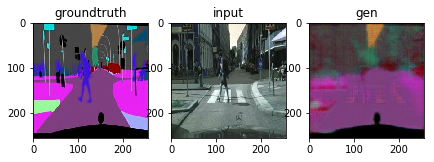

[Epoch 20/200] [Batch 92/93] [D loss: 0.179655] [G loss: 12.479004, pixel: 0.119636, adv: 0.515376] ETA: 14:27:11.680151

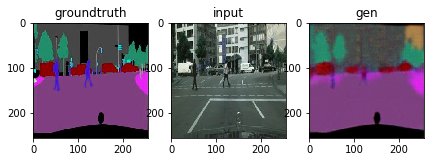

[Epoch 30/200] [Batch 92/93] [D loss: 0.083321] [G loss: 12.486429, pixel: 0.111975, adv: 1.288903] ETA: 13:46:59.294916

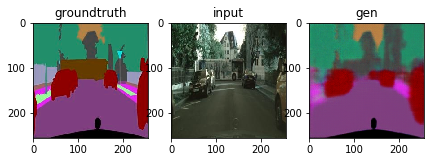

[Epoch 40/200] [Batch 92/93] [D loss: 0.006223] [G loss: 12.406036, pixel: 0.113537, adv: 1.052297] ETA: 12:36:38.982726

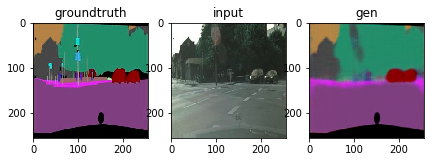

[Epoch 48/200] [Batch 64/93] [D loss: 0.042319] [G loss: 10.317092, pixel: 0.094819, adv: 0.835176] ETA: 12:04:35.376202

In [0]:
g_losses1 = []
d_losses1 = []
lambda_pixel = 100.0
n_epochs = 200
onecyc = OneCycle(len(train_loader)*n_epochs,0.0005)
cuda = True
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
prev_time = time.time()
import cv2

for epoch in range(n_epochs):
    for i, (img2,img1) in enumerate(train_loader):
        img1 = Variable(img1.type(torch.cuda.FloatTensor))
        img2 = Variable(img2.type(torch.cuda.FloatTensor))
        
        valid = Variable(Tensor(img1.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(img1.shape[0], *patch).fill_(0.0), requires_grad=False)
        
        optimizer_G.zero_grad()
        
        gen_imgs = gen(img2)
        pred_fake = dis(gen_imgs,img2)
        g_loss = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(gen_imgs, img1)
        loss_G = g_loss + lambda_pixel * loss_pixel
        loss_G.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        pred_real = dis(img2,img1)
        real_loss = criterion_GAN(pred_real, valid)
        pred_fake = dis(gen_imgs.detach(),img2)
        fake_loss = criterion_GAN(pred_fake, fake)
        d_loss = (real_loss + fake_loss) / 2
      
        d_loss.backward()
        optimizer_D.step()
        g_losses1.append(g_loss.item())
        d_losses1.append(d_loss.item())
        batches_done = epoch * len(train_loader) + i
        batches_left = n_epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        lr = onecyc.calc_lr()
        update_lr(optimizer_G, lr)
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(train_loader),
                d_loss.item(),
                loss_G.item(),
                loss_pixel.item(),
                g_loss.item(),
                time_left,
            )
        )

    if(epoch%10==0):
      vis_gen(img1[0],img2[0],gen_imgs[0])
      path = '/content/state_dict' + '/{}.h5'.format(epoch)
      torch.save(gen.state_dict(), path)